In [93]:
#DTW 클러스터링
#스케일링 전 변수 특성 파악
stock_info['daily_mov'].describe()

count    82215.000000
mean         2.061988
std          5.820376
min          0.000000
25%          0.205000
50%          0.610000
75%          1.840000
max        257.580000
Name: daily_mov, dtype: float64

In [94]:
trade_info['tot_hld_qty'].describe()

count    8.221500e+04
mean     7.787425e+04
std      4.563105e+05
min      1.400000e+01
25%      7.100000e+02
50%      3.321000e+03
75%      1.746600e+04
max      9.848135e+06
Name: tot_hld_qty, dtype: float64

In [95]:
trade_info['pft_ivo_rt'].describe()

count    82215.000000
mean         0.403343
std          0.362737
min          0.000000
25%          0.046200
50%          0.308500
75%          0.757100
max          1.000000
Name: pft_ivo_rt, dtype: float64

In [96]:
#총보유수량이 다른 변수에 비해 단위 차이가 큰 것을 확인, 단위 차이를 유사한 수준으로 조정해주기 위해 로그 변환 진행
trade_info['tot_hld_qty']=np.log1p(trade_info['tot_hld_qty'])

In [97]:
trade_info['tot_hld_qty'].describe()

count    82215.000000
mean         8.306872
std          2.270883
min          2.708050
25%          6.566672
50%          8.108322
75%          9.768069
max         16.102793
Name: tot_hld_qty, dtype: float64

In [98]:
#분석을 위해 피벗테이블 형태로 변환
stock1 =trade_info.pivot(index='bse_dt', columns='tck_iem_cd', values='pft_ivo_rt')
stock2 =stock_info.pivot(index='bse_dt', columns='tck_iem_cd', values='daily_mov')
stock3 =trade_info.pivot(index='bse_dt', columns='tck_iem_cd', values='tot_hld_qty')

In [99]:
stocks = [stock1, stock2, stock3]

In [100]:
#노이즈를 제거하기 위해 5일기준 이동평균의 값을 이용
stock=trade_info[['tck_iem_cd','bse_dt','tot_hld_qty','pft_ivo_rt']]
stock=pd.merge(stock,stock_info[['tck_iem_cd','bse_dt','daily_mov']],on=['bse_dt','tck_iem_cd'],how='inner')

x_list = stock['tck_iem_cd'].unique()

for var in stocks:
    for stock in x_list:
        var[stock] = var[stock].rolling(window=5).mean()
    var.dropna(inplace=True)

In [101]:
#결측치 확인
stocks = [stock1,stock2, stock3]

for i, stock in enumerate(stocks, 1):
    print(f"Missing values in stock{i}:")
    print(stock.isna().sum().sum())
    print()

Missing values in stock1:
0

Missing values in stock2:
0

Missing values in stock3:
0



In [102]:
#정규화 진행
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled1 = scaler.fit_transform(stock1.T)
scaled2 = scaler.fit_transform(stock2.T)
scaled3 = scaler.fit_transform(stock3.T)

In [103]:
#종합 데이터셋 생성
scaled_total = np.dstack([scaled1, scaled2, scaled3])

In [104]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

In [105]:
# 실루엣 점수 계산 함수 정의
def calculate_dtw_clusters(data, min_clusters, max_clusters):
    wcss = []  
    silhouette_scores = [] 
    for n_clusters in range(min_clusters, max_clusters + 1):
        km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=31, n_jobs=-1)
        cluster_labels = km_dtw.fit_predict(data)
        wcss.append(km_dtw.inertia_)
        sil_score = silhouette_score(data.reshape(data.shape[0], -1), cluster_labels)
        silhouette_scores.append(sil_score)
    return wcss, silhouette_scores

In [106]:
#WCSS 기반 Elbow Point Plot 함수 정의
def plot_elbow_silhouette(wcss, min_clusters, max_clusters):
    x = range(min_clusters, max_clusters + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(x, wcss, marker='o')
    plt.title('Elbow Method (WCSS)')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.tight_layout()
    plt.show()

In [31]:
# 최소/최대 군집 개수 설정
min_clusters = 2
max_clusters = 10

#클러스터 실행
wcss, silhouette_scores = calculate_dtw_clusters(scaled_total, min_clusters, max_clusters)

In [32]:
#실루엣계수 확인
silhouette_scores

[0.5148369547688579,
 0.35813251264936447,
 0.27409714336752067,
 0.28429834040514457,
 0.24327974686404205,
 0.22693049413038005,
 0.23445119535365863,
 0.21951029279391374,
 0.20828913294280363]

In [33]:
#WCSS 확인
wcss

[2.9169161883146,
 2.1730226969089905,
 1.6614426157102242,
 1.4228297269128793,
 1.2572838923047842,
 1.1110680747492938,
 1.0274678183011812,
 0.9687014098063703,
 0.9069759143762441]

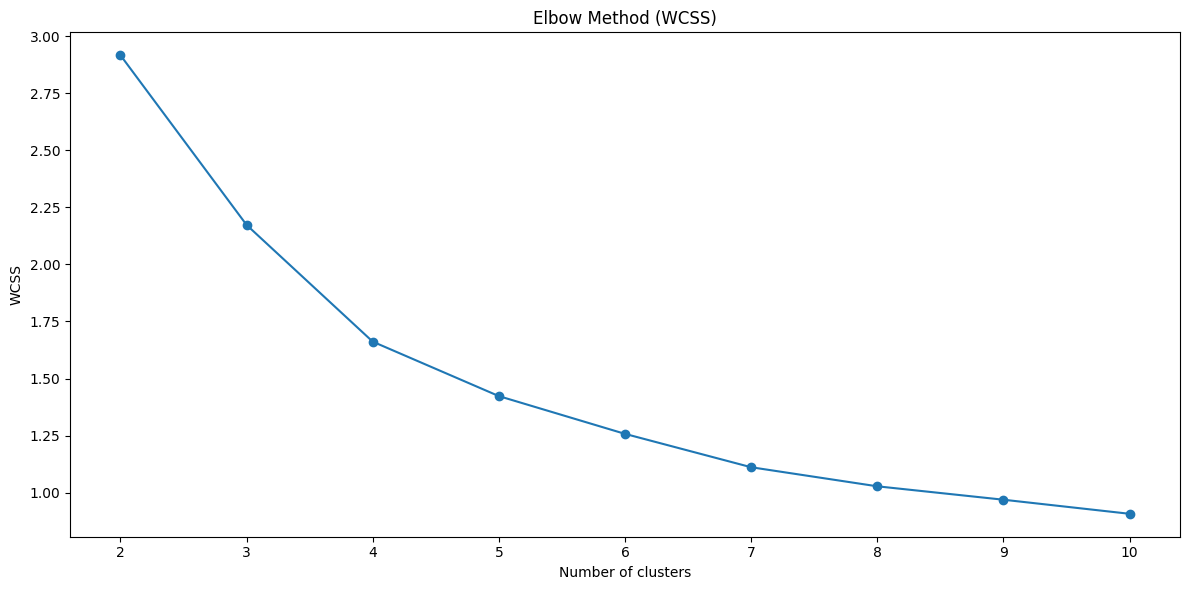

In [34]:
#Elbow point 확인
plot_elbow_silhouette(wcss, 2, 10)

In [112]:
#5개 클러스터로 최종 클러스터링 진행
n_clusters = 5
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=31, n_jobs=-1)
cluster_labels = km_dtw.fit_predict(scaled_total)

In [36]:
#실루엣 계수
silhouette_score(scaled_total.reshape(scaled_total.shape[0], -1), cluster_labels)

0.28429834040514457

In [113]:
cluster_labels = cluster_labels + 1

In [114]:
#클러스터 안에 포함된 주식 종목 개수 확인
for i in range(1, n_clusters + 1):
    print(f"Cluster {i}: {len(np.where(cluster_labels == i)[0])}")

Cluster 1: 233
Cluster 2: 351
Cluster 3: 282
Cluster 4: 168
Cluster 5: 271


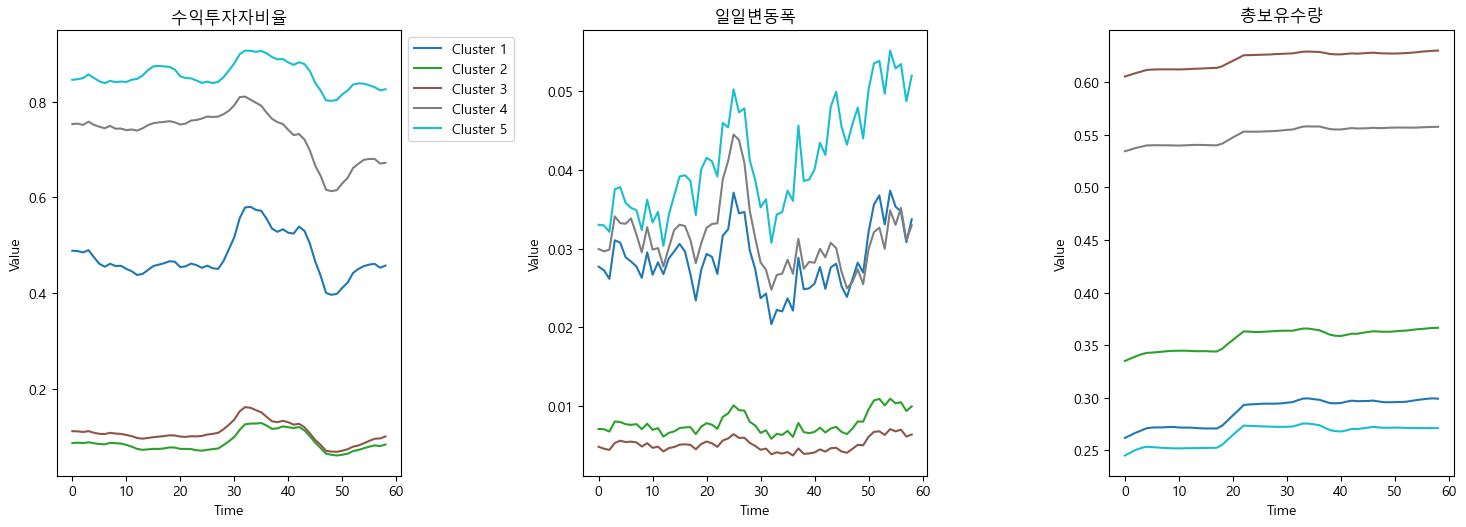

In [116]:
n_samples, n_timestamps, n_features = scaled_total.shape
cluster_means = np.empty((n_clusters, n_timestamps, n_features))

for cluster_idx in range(1, n_clusters + 1):  # 1~5 범위
    cluster_data = scaled_total[cluster_labels == cluster_idx]
    cluster_mean = np.mean(cluster_data, axis=0)
    cluster_means[cluster_idx - 1] = cluster_mean  # 인덱스 조정

variable_names = ['수익투자자비율', '일일변동폭', '총보유수량']

colors = plt.cm.get_cmap('tab10', n_clusters)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

n_rows, n_cols = 3, 4
plt.figure(figsize=(20, 15))

for feature_idx in range(n_features):
    plt.subplot(n_rows, n_cols, feature_idx + 1)
    for cluster_idx in range(n_clusters):
        plt.plot(cluster_means[cluster_idx, :, feature_idx], 
                 label=f'Cluster {cluster_idx + 1}',  # 1부터 시작하도록 표시
                 color=colors(cluster_idx))
    
    plt.title(f'{variable_names[feature_idx]}')
    plt.xlabel('Time')
    plt.ylabel('Value')

plt.subplot(n_rows, n_cols, 1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [117]:
#클러스터링 결과 저장
result=pd.DataFrame(cluster_labels)
result.columns=['cluster']

In [118]:
stock_nm=pd.DataFrame(stock_info['tck_iem_cd'].unique())
stock_nm.columns=['tck_iem_cd']

In [119]:
final_res=pd.concat([stock_nm,result],axis=1)

In [120]:
final_res.head()

,tck_iem_cd,cluster
0,A,5
1,AA,4
2,AADI,2
3,AAL,3
4,AAN,2


In [121]:
#데이터와 클러스터 결과 병합
cust_info=pd.merge(final_res,cust,on='tck_iem_cd',how='inner')
plot_df=pd.merge(plot_df,final_res,on='tck_iem_cd',how='inner')

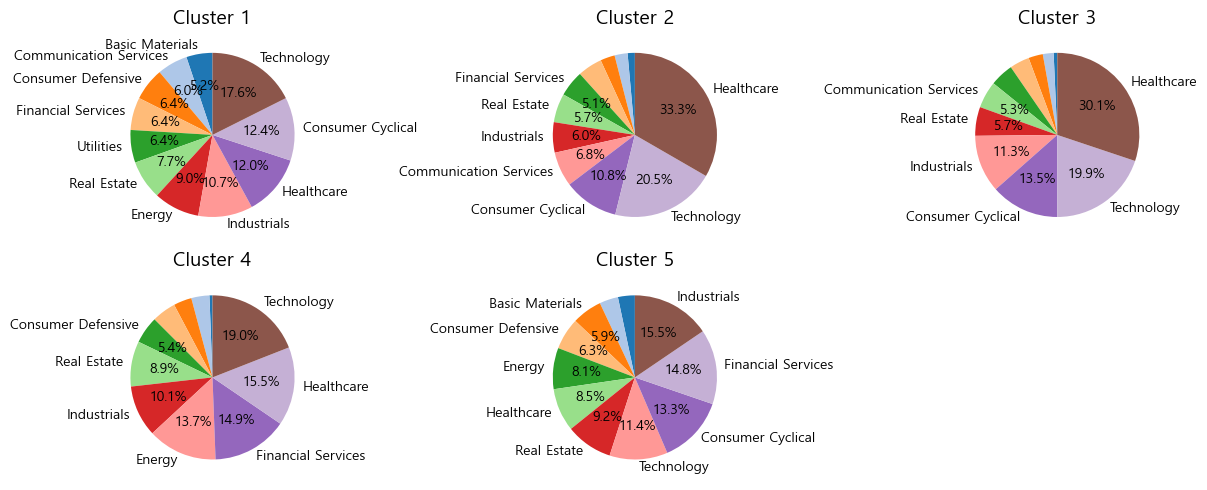

In [124]:
# 그룹별 개수 계산
group_counts = plot_df.groupby(['cluster', 'ser_cfc_nm']).size()
categories = sorted(plot_df['cluster'].unique())

# 5개 군집이므로 2x3 형태에서 한 칸은 공백
rows, cols = 2, 3  

# 5% 미만 라벨 숨기기
def autopct_format(pct):
    return f'{pct:.1f}%' if pct >= 5 else ''

colors = sns.color_palette("tab20", 20)
fig, axes = plt.subplots(rows, cols, figsize=(12, 5))

# 서브플롯을 1D 리스트처럼 다룰 수 있도록 평탄화
axes = axes.flatten()

for i, category in enumerate(categories):
    sorted_counts = group_counts.loc[category].sort_values(ascending=True)
    total = sorted_counts.sum()  
    pct_values = sorted_counts / total * 100  

    # 5% 이상인 Type만 라벨 표시
    labels = [label if pct >= 5 else '' for label, pct in zip(sorted_counts.index, pct_values)]

    sorted_counts.plot.pie(labels=labels, autopct=autopct_format, startangle=90, legend=False, 
                           ax=axes[i], colors=colors[:len(sorted_counts)])
    axes[i].set_title(f'Cluster {category}', fontsize=14)
    axes[i].set_ylabel('')  

# 남은 빈 서브플롯은 비워두기
for j in range(len(categories), rows * cols):
    axes[j].axis('off')

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.tight_layout()
plt.show()


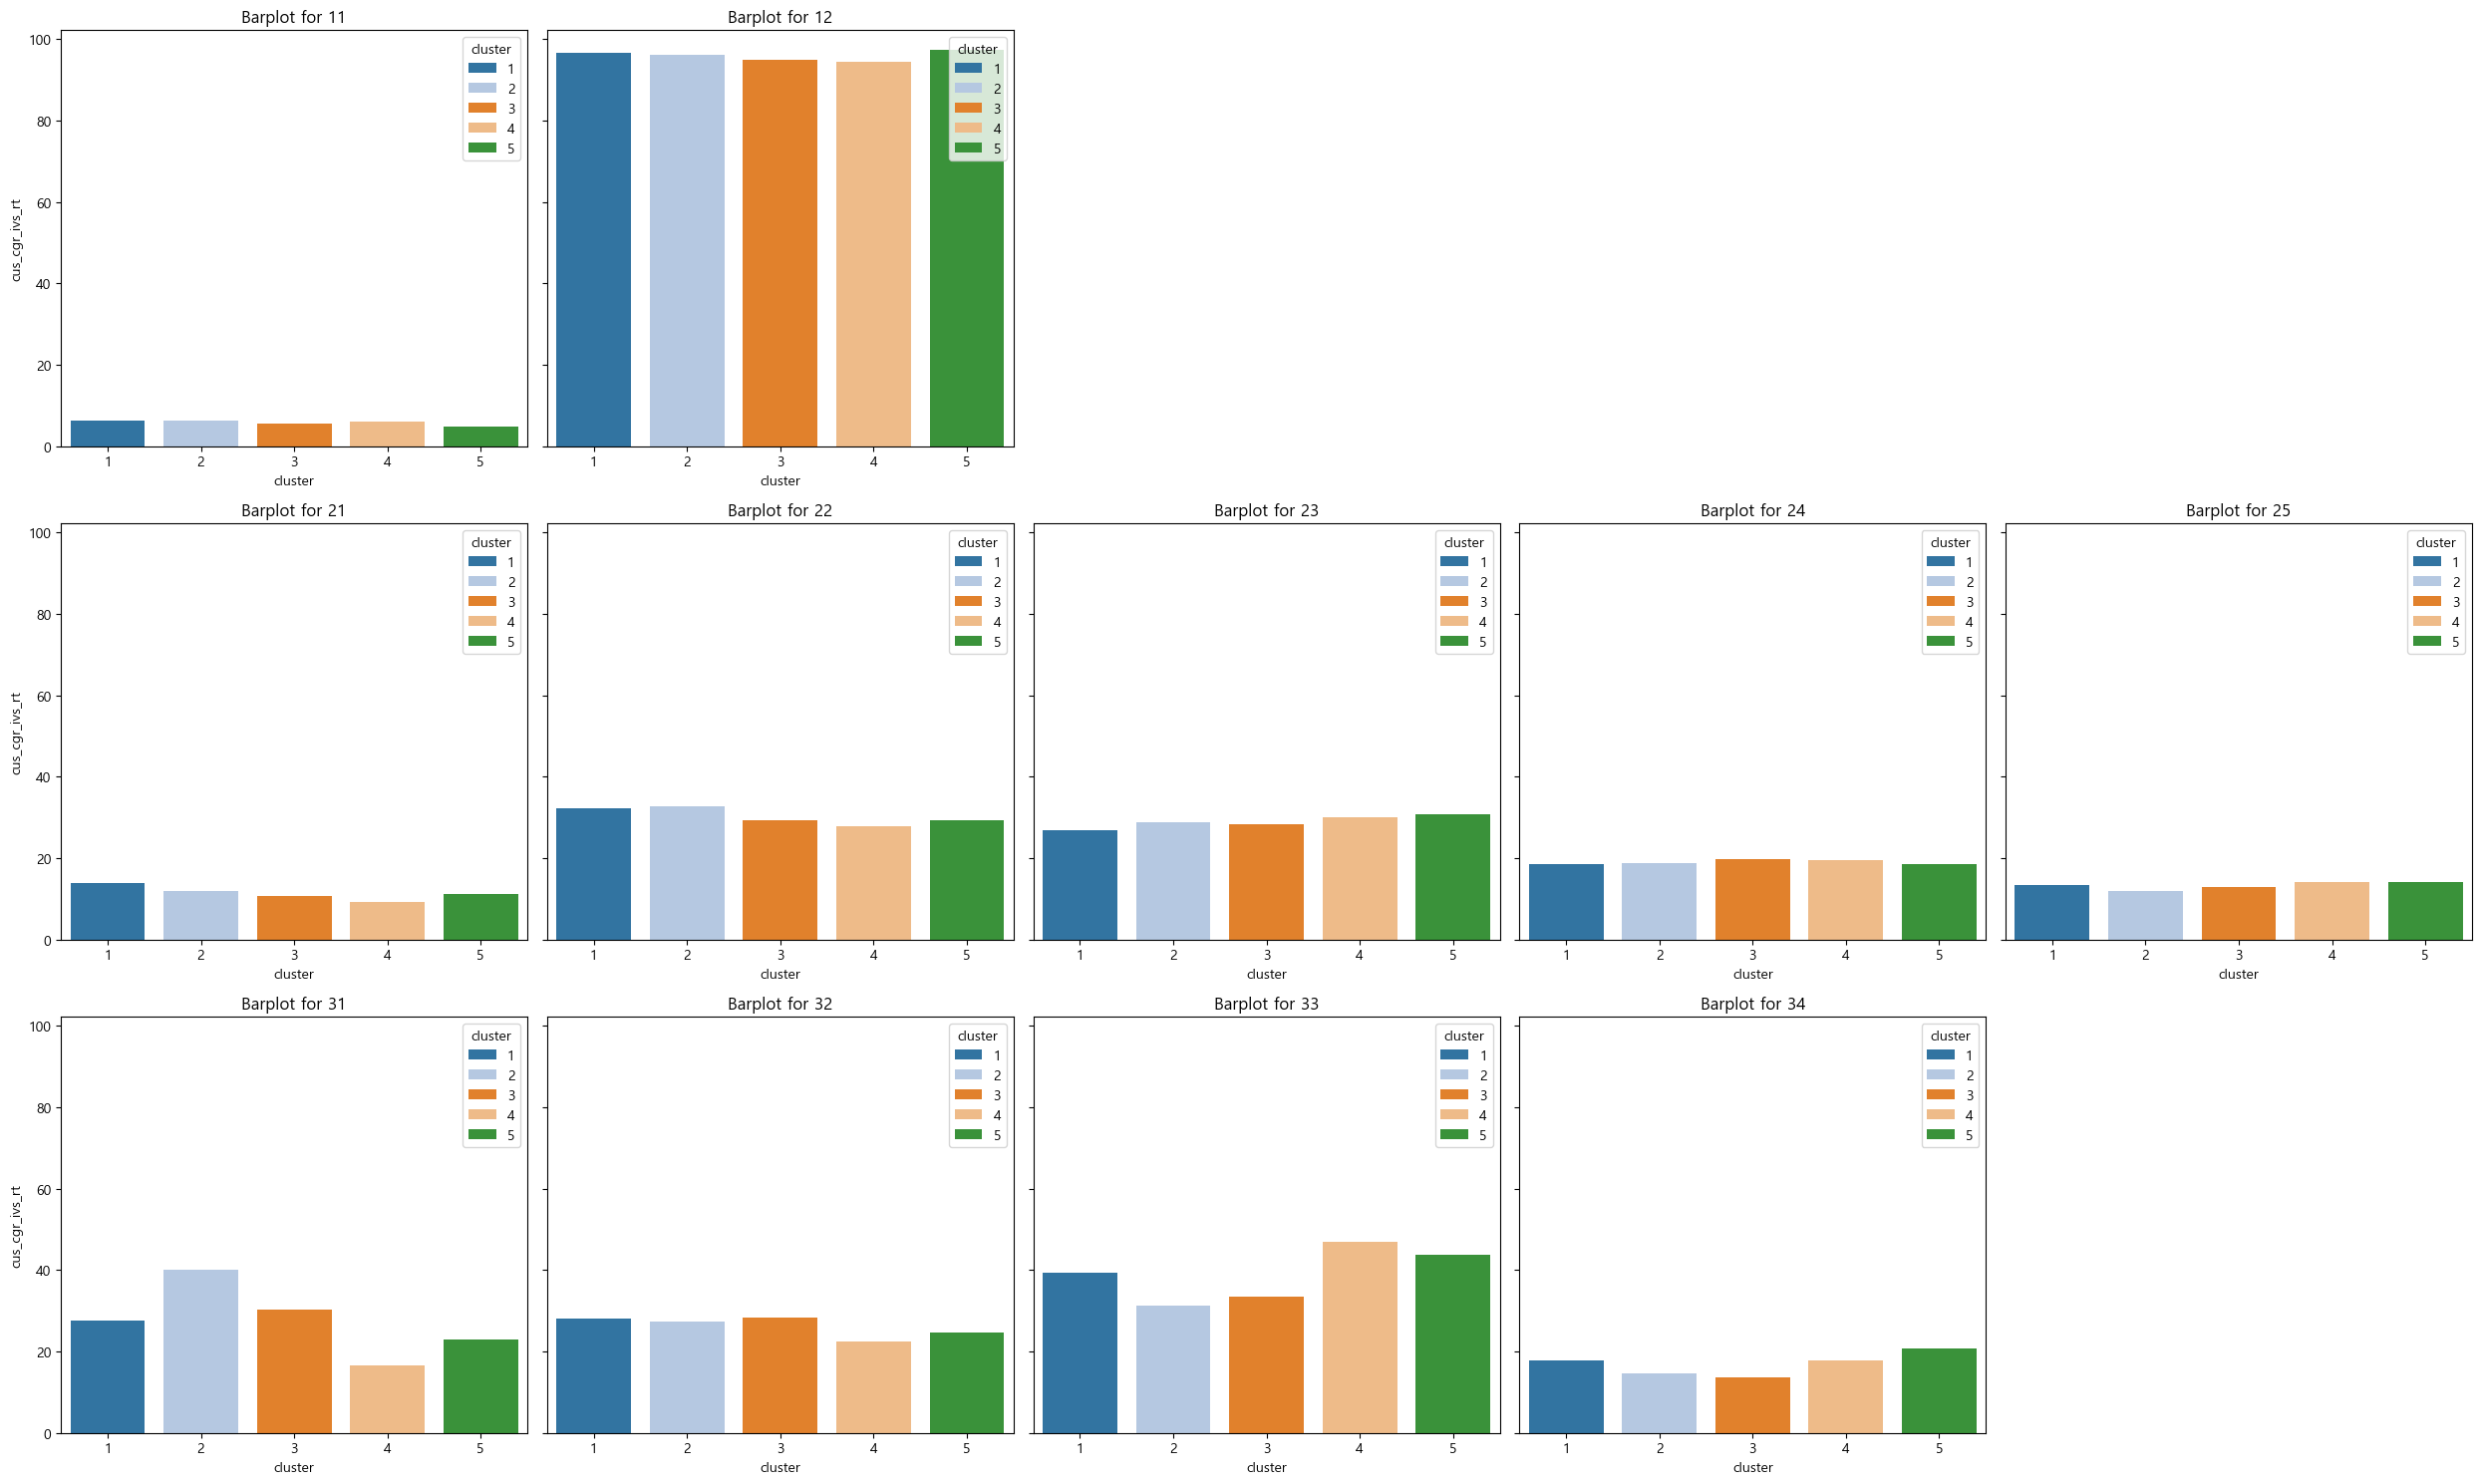

In [126]:
#클러스터별 고객 투자비율 평균값 비교 시각화 
cust_info=cust_info.groupby(['cus_cgr_mlf_cd','cluster'])['cus_cgr_ivs_rt'].mean()
cust_info=pd.DataFrame(cust_info)
cust_info.reset_index(inplace=True)

row_col_counts = [2, 5, 4] 
cd_nm = cust_info['cus_cgr_mlf_cd'].unique()
num_plots = len(cd_nm)
palette = sns.color_palette("tab20")
fig, axes = plt.subplots(len(row_col_counts), max(row_col_counts), figsize=(max(row_col_counts) * 5, len(row_col_counts) * 5), sharey=True)
plot_idx = 0

for row, cols in enumerate(row_col_counts):
    for col in range(cols):
        if plot_idx >= num_plots:
            break
        val = cd_nm[plot_idx]
        subset = cust_info[cust_info['cus_cgr_mlf_cd'] == val] 
        sns.barplot(x='cluster', y='cus_cgr_ivs_rt', hue='cluster', data=subset, ax=axes[row, col], dodge=False, palette=palette)  
        
        axes[row, col].set_title(f'Barplot for {val}')  
        axes[row, col].set_xlabel('cluster') 
        axes[row, col].set_ylabel('cus_cgr_ivs_rt') if col == 0 else axes[row, col].set_ylabel('')
        plot_idx += 1

for i in range(len(row_col_counts)):
    for j in range(row_col_counts[i], max(row_col_counts)):
        fig.delaxes(axes[i, j])

plt.tight_layout()
plt.show()

In [ ]:
df=trade_info[['tck_iem_cd','bse_dt','pft_ivo_rt']]
df=pd.merge(df,stock_info['daily_mov'],on=['tck_iem_cd','bse_dt'],how='inner')
df=pd.merge(df,stock_info['daily_mov'],on=['tck_iem_cd','bse_dt'],how='inner')
stock1 =trade_info.pivot(index='bse_dt', columns='tck_iem_cd', values='pft_ivo_rt')
stock2 =stock_info.pivot(index='bse_dt', columns='tck_iem_cd', values='daily_mov')
stock3 =trade_info.pivot(index='bse_dt', columns='tck_iem_cd', values='tot_hld_qty')

In [46]:
#유사사 투자자의 투자 고려 비중을 활용한 ETF 추천 점수 산출
#1.각 기준별로 투자비율이 높은 순으로 클러스터에 더 높은 가중치 부여 
#고객분류 기준으로 클러스터별 Rank 산출
lst=list(cust_info['cus_cgr_mlf_cd'].unique())
cust_rk=pd.DataFrame(cust_info['cluster'].unique())
cust_rk.columns=['cluster']
for i in lst:
    cust_cgr=cust_info[cust_info['cus_cgr_mlf_cd']==i].copy()
    cust_cgr.drop('cus_cgr_mlf_cd',axis=1,inplace=True)
    cust_cgr['rank']=cust_cgr['cus_cgr_ivs_rt'].rank(ascending=True)
    cust_cgr.drop('cus_cgr_ivs_rt',axis=1,inplace=True)
    cust_rk=pd.merge(cust_rk,cust_cgr,on='cluster',how='inner',suffixes=(None, f'_rank_{i}'))
cust_rk.columns=['cluster',11, 12, 21, 22, 23, 24, 25, 31, 32, 33, 34]

In [47]:
#분류 기준별 가중치 부여 결과
cust_rk

,cluster,11,12,21,22,23,24,25,31,32,33,34
0,0,4.0,4.0,5.0,4.0,1.0,2.0,3.0,3.0,4.0,3.0,4.0
1,1,5.0,3.0,4.0,5.0,3.0,3.0,1.0,5.0,3.0,1.0,2.0
2,2,2.0,2.0,2.0,2.0,2.0,5.0,2.0,4.0,5.0,2.0,1.0
3,3,3.0,1.0,1.0,1.0,4.0,4.0,5.0,1.0,1.0,5.0,3.0
4,4,1.0,5.0,3.0,3.0,5.0,1.0,4.0,2.0,2.0,4.0,5.0


In [54]:
#ETF 점수와 관련된 주식 변수 선정
sc_df=trade_info[['bse_dt','tck_iem_cd','tco_avg_pft_rt']]
sc_df=pd.merge(sc_df,stock_info[['bse_dt','tck_iem_cd','iem_end_pr','acl_trd_qty']],on=['bse_dt','tck_iem_cd'],how='inner')

In [55]:
#종목별 수익률 평균 계산
profit = sc_df[['tck_iem_cd','tco_avg_pft_rt']].groupby('tck_iem_cd').mean().reset_index()
profit.columns = ['tck_iem_cd', 'profit']

In [56]:
#종목별 가격 표준편차 계산
stability = sc_df[['tck_iem_cd','iem_end_pr']].groupby('tck_iem_cd').std().reset_index()
stability.columns = ['tck_iem_cd', 'stability']

In [57]:
#종목별 거래량 평균 계산
volume = sc_df[['tck_iem_cd','acl_trd_qty']].groupby('tck_iem_cd').mean().reset_index()
volume.columns = ['tck_iem_cd', 'volume']

In [58]:
stk_sc_df=pd.merge(profit,stability,on='tck_iem_cd',how='inner')
stk_sc_df=pd.merge(stk_sc_df,volume,on='tck_iem_cd',how='inner')

In [59]:
stk_sc_df.describe()

,profit,stability,volume
count,1305.000000,1305.000000,1.305000e+03
mean,-12.280758,6.868416,3.965009e+06
std,40.484624,49.090951,1.104737e+07
min,-98.272131,0.022278,7.845180e+03
25%,-43.251148,0.459905,6.388423e+05
50%,-6.027541,1.464373,1.589477e+06
75%,14.092787,4.509081,3.662580e+06
max,122.681311,1414.890571,3.021654e+08


In [60]:
#범주화 진행 - 10분위 간격으로 범주화 
#범주화 함수 정의
def categorize_by_percentile1(series, num_categories=10):
    percentiles = np.linspace(0, 100, num_categories + 1)
    bins = np.percentile(series, percentiles)
    labels = range(1, num_categories + 1)
    categorized_series = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    categorized_series = categorized_series.astype(int)
    categorized_df=pd.DataFrame(categorized_series)
    return categorized_df

In [61]:
#범주화 함수 정의 - 값이 작을 수록 안정성이 크기 때문에 역순으로 범주화 필요
def categorize_by_percentile2(series, num_categories=10):
    percentiles = np.linspace(0, 100, num_categories + 1)
    bins = np.percentile(series, percentiles)
    labels = range(num_categories, 0, -1)
    categorized_series = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    categorized_series = categorized_series.astype(int)
    categorized_df=pd.DataFrame(categorized_series)
    return categorized_df

In [62]:
#범주화 진행
stk_sc_df['profit']=categorize_by_percentile1(stk_sc_df['profit'])
stk_sc_df['volume']=categorize_by_percentile1(stk_sc_df['volume'])
stk_sc_df['stability']=categorize_by_percentile2(stk_sc_df['stability'])
stk_sc=pd.merge(final_res,stk_sc_df,on='tck_iem_cd',how='inner')
stk_sc.head()

,tck_iem_cd,cluster,profit,stability,volume
0,A,4,8,3,7
1,AA,3,7,3,9
2,AADI,1,2,10,2
3,AAL,2,4,7,10
4,AAN,1,2,7,4


In [63]:
#추천에 활용할 ETF 점수 변수 선정
etf = etf[['bse_dt', 'etf_iem_cd', 'acl_pft_rt_z_sor', 'vty_z_sor']]
#최근 경향을 반영하기 위해 5일 데이터 선택 
dates = sorted(etf['bse_dt'].unique())[-5:]
etf = etf[etf['bse_dt'].isin(dates)]
etf = etf.groupby('etf_iem_cd').mean().reset_index().drop('bse_dt', axis=1)

In [64]:
etf_volm.columns=['etf_iem_cd','volume']
#5일 평균 거래량이 0 이상인 etf만 선정
etf_volm=etf_volm[etf_volm['volume']>0]
etf_volm.describe()

,volume
count,3.650000e+02
mean,8.589946e+05
std,3.511394e+06
min,1.080000e+01
25%,1.646160e+04
50%,7.575380e+04
75%,3.936542e+05
max,4.335159e+07


In [65]:
#거래량의 큰 단위 차이를 조정해주기 위해 로그 변환 진행
etf_volm['volume'] = np.log1p(etf_volm['volume'])
#거래량 값을 점수 데이터의 범위 (0~100)로 조정
scaler = MinMaxScaler(feature_range=(0, 100))
etf_volm['volume'] = scaler.fit_transform(etf_volm[['volume']])

In [66]:
#추천에 활용할 etf 데이터 종합
fin_etf=pd.merge(etf,etf_volm,on='etf_iem_cd',how='inner')
fin_etf.head()

,etf_iem_cd,acl_pft_rt_z_sor,vty_z_sor,volume
0,AIEQ,54.651911,21.363911,42.085204
1,AIRR,92.466907,6.213074,66.968484
2,AIVL,35.369681,71.537658,35.077834
3,AIYY,0.086776,1.509847,53.051487
4,ALTL,7.046243,58.779436,50.823664


In [67]:
#추천 예시
#투자 선호도 비중 산출 함수 정의 - 추후 서비스 구현 코드에 활용
def calculate_combined_value(dt1,dt2,user):
    user_df=dt1[['cluster']+ user]
    user_df['rank']=user_df[user].sum(axis=1)
    df=user_df[['cluster','rank']]
    res_df=dt2.copy()
    res_df.drop('tck_iem_cd',axis=1,inplace=True)
    res_df=res_df.groupby('cluster').mean().reset_index()
    norm_df=res_df.drop('cluster',axis=1)
    row_min =norm_df.min(axis=0)
    norm_df =(norm_df.subtract(row_min, axis=1))
    res_df=pd.concat([res_df['cluster'],norm_df],axis=1)
    for i in range(len(res_df)):
        cluster=res_df.loc[i,'cluster']
        rank_value=df.loc[df['cluster']==cluster,'rank'].values[0]
        res_df.iloc[i,1:]*=rank_value
    profit_score=res_df['profit'].sum(axis=0)
    stability_score=res_df['stability'].sum(axis=0)
    volume_score=res_df['volume'].sum(axis=0)
    total_score=profit_score+stability_score+volume_score
    profit_score=round(profit_score/total_score*100)
    stability_score = round(stability_score / total_score*100)
    volume_score = round(volume_score / total_score*100)
    ratio_df=pd.DataFrame({'profit':[profit_score],'stability': [stability_score],'volume': [volume_score]})
    return ratio_df

In [68]:
#ETF 추천 점수 계산 함수 정의 - 추후 서비스 구현 코드에 활용
def etf_score(dt3,res_dt):
    etf_info=dt3.copy()
    profit_val=res_dt['profit'][0]
    stability_val=res_dt['stability'][0]
    volume_val=res_dt['volume'][0]
    etf_rec_sc=pd.DataFrame(columns=['profit','stability','volume','etf_score'])
    etf_rec_sc['profit'] = etf_info['acl_pft_rt_z_sor'] * (profit_val/100)
    etf_rec_sc['stability'] = etf_info['vty_z_sor'] * (stability_val/100)
    etf_rec_sc['volume'] = etf_info['volume'] * (volume_val/100)
    etf_rec_sc['etf_score'] = etf_rec_sc.sum(axis=1)
    etf_rec_sc=pd.concat([etf_info['etf_iem_cd'],etf_rec_sc],axis=1)
    etf_rec_sc=etf_rec_sc.sort_values('etf_score', ascending=False)
    curate_etf = list(etf_rec_sc[0:10]['etf_iem_cd'])
    return curate_etf

In [69]:
#추천 예시
user=[11, 21, 31]
res=calculate_combined_value(cust_rk,stk_sc,user)
res=res
print(res,etf_score(fin_etf,res))

   profit  stability  volume
0      40         37      23 ['XLF', 'FELC', 'CGDV', 'SPY', 'CGUS', 'SPLG', 'SPHQ', 'VOO', 'IVV', 'DGRW']
